# MODELO DE METAPOBLACIONES (Covid-19 Bogotá)

En este notebook podrá encontrar el procedimiento para la:

1. [Definición de los bloques de fechas para el ajuste de parámetros](#bloques_epidemiologicos)
1. [Definición de los parámetros epidemiológicos](#parametros_epidemiologicos)
1. [Definición de la ubicación de los archivos](#mas_parametros)
1. [Funciones requeridas para la simulación](#funciones)
1. [Cálculo de nuevos infectados](#nuevos_infectados)
1. [Función simular](#simular)
1. [Función optimizar](#optimizar)
1. [Ejecución](#ejecucion)
1. [Gráficas](#grafica)
1. [Cálculo Rt](#Rt)

In [1]:
# Importando paquetes necesarios
from datetime import date, datetime
import meta_uh_sim as sim
from time import time
import pandas as pd
import numpy as np
import pickle
import nlopt
import matplotlib.pyplot as plt

## <a id='bloques_epidemiologicos'></a> 1. Definición del conjunto o bloques de fechas a ajustar los parámetros epidemiológicos.

In [2]:
# ===================================================================================================================
#                                             PARAMETROS
# ===================================================================================================================
# Definicion de los rangos de fechas para calcular y ajustar los parametros: beta, sigma, 1-theta.
#    >> day_ini_fit:   Fecha inicio de ajuste de los parametros
#    >> day_fin_fit:   Fecha final de ajuste de los parametros
#    >> paramsCalculados:  None, para calcular los parametros, en otro caso, ingrsar los ya calculados.

info_bloques = {
    'bloque1' : {'idx': 1, 
                 'day_ini_fit': '15/3/2020',  
                 'day_fin_fit': '14/9/2020',  
                 'paramsPreCalculados': None,
                 #"paramsPreCalculados" : [1.116225133598177, 0.08964786639309927, 0.40000078702873504]
                },
    'bloque2' : {'idx': 2,
                 'day_ini_fit':'14/9/2020', 
                 'day_fin_fit': '8/12/2020',
                 'paramsPreCalculados': None,
                 #"paramsPreCalculados": [1.0176475426253768, 0.13298510465905808, 0.4000009429313621]
                },
    'bloque3' : {'idx': 3,
                 'day_ini_fit': '8/12/2020', 
                 'day_fin_fit': '10/1/2021',
                 'paramsPreCalculados': None,
                 #"paramsPreCalculados": [1.0157566873189474, 0.22712761382005947, 0.40000072121872676]
                },
    'bloque4' : {'idx': 4,
                 'day_ini_fit': '10/1/2021',
                 'day_fin_fit': '1/3/2021',
                 'paramsPreCalculados': None,
                 #"paramsPreCalculados": [0.7010637481646708, 0.27350217189209247, 0.40000117578741023]
                },
    'bloque5' : {'idx': 5,
                'day_ini_fit': '1/3/2021',
                'day_fin_fit': '1/5/2021',
                 'paramsPreCalculados': None,
                 #"paramsPreCalculados": [0.7513131078496125, 0.5, 0.4000160629890279]
                },
    'bloque6' : {'idx': 6,
                 'day_ini_fit': '1/5/2021',
                 'day_fin_fit': '1/9/2021',
                 'paramsPreCalculados': None,
                 #"paramsPreCalculados": [1.6277577046209473, 0.20113274483558297, 0.4]
                }
}

## <a id='parametros_epidemiologicos'></a> 2. Definción de los parámetros epidemiológicos

Aquí se definen los parametros epidemiologicos. Está comentado debido a que se definen una única vez. 

Ejemplo: `epi_params` se define creando el diccionario con el valor de cada parámetro, luego al final en la última línea de esta celda de código con la función `save_pickle` se guardan los parámetros como un archivo `.json` de forma que se pueda cargar más adelante en el código de la simulación.

In [3]:
#=====================================================================================
#                             PARAMETROS DE INFECCION
#=====================================================================================
epi_params = {
    'ExposureRate': '1.0', 
    'InfectionRate': '0.5330',
    'TransitionRate_ir': '0.12328', 
    'TransitionRate_ih': '0.22', 
    'TransitionRate_iu': '0.22', 
    'TransitionRate_id': '0.09', 
    'TransitionRate_hr': '0.1052', 
    'TransitionRate_hd': '0.2958', 
    'TransitionRate_ud': '0.1297', 
    'TransitionRate_hu': '0.1', 
    'TransitionRate_uh': '0.09', 
    'ScalingFactor': '1', 
    'RecoveryRateAsymptomatic': '0.5', 
    'Prob_S_ymptomaticToRecover': '0.8575', 
    'Prob_S_ymptomaticToHospital': '0.0792', 
    'Prob_S_ymptomaticToUci': '0.0044', 
    'Prob_HospitalizedToRecover':'0.5765', 
    'Prob_HospitalizedToUci': '0.075',
    'Prob_UciToHospitals': '0.69',
    'Prob_A_symptomaticToRecover': '1.0'
}

## <a id='mas_parametros'></a> 3. Definción de parámetros y ubicaciones de archivos

In [4]:
# Nombre archivos -----------------------------------------------------------------------------------------------------
PATH_MATRIZ = 'data/matrix_upz_google_transit_lin_2021.txt' 
PATH_PARAMS = 'data/params_google_upz_ratio_transit_exp_2021.txt' 
PATH_zat_loc = 'data/upz_loc.csv' 
# Leyendo archivos ----------------------------------------------------------------------------------------------------
paramfile = pd.read_csv(PATH_PARAMS, delimiter=" ", dtype={0: str}, header=None)
matriz_mov = pd.read_csv(PATH_MATRIZ, delimiter=' ', names=['from','to','day','mov']).rename(columns={"day":"week"})
upz2loc = pd.read_csv(PATH_zat_loc) 
# Más parámetros -------------------------------------------------------------------------------------------------------
epi_params['PatchFile'] = 'data/upz_pop_vivhog.txt'
epi_params['NetworkType'] = 'Weekly'    
epi_params['SeedFile'] = 'data/seeds_upz.txt'
epi_params['VaxFile'] = 'data/test_vax_BOG.txt'
epi_params['VaxDelay'] = '0' 
epi_params['VaxEfficacy'] = '0'
epi_params['Duration'] = 379
epi_params['OutputFile'] = 'outputs/simModel_patch_cases_simulados.csv'
epi_params['OutputFormat'] = 'Whole'
epi_params['LogFile'] = 'outputs/log_file.log'
epi_params['Model']= 'Mobility'

## <a id='funciones'></a> 4. Funciones para manipulación de archivos

In [5]:
# Id Localidades
localityCode = {'Usaquén':1, 'Chapinero':2, 'Santa Fe':3, 'San Cristóbal':4,
                'Usme':5, 'Tunjuelito':6, 'Bosa':7, 'Kennedy':8,'Engativá':10,
                'Suba':11,'Barrios Unidos':12, 'Teusaquillo':13, 'Los Mártires':14,
                'Antonio Nariño':15,'Puente Aranda':16, 'La Candelaria':17, 
                'Rafael Uribe Uribe':18, 'Ciudad Bolívar':19,'Fontibón':9}

In [6]:
# Convierte una fecha a dias
def fecha2dia(fecha):
    fecha = datetime.strptime(fecha, '%d/%m/%Y')
    fecha_ini = datetime.strptime("30/12/2019", '%d/%m/%Y') # Fecha semana 1 del 2020
    return (fecha-fecha_ini).days

In [7]:
# Esta funcion genera el archivo paramfile para el bloque requerido.
def write_paramfile(dia_ini, file):
    paramfile1 = paramfile.iloc[:, dia_ini : dia_ini+epi_params['Duration']]
    paramfile1.insert(0,"P",paramfile[0])
    paramfile1.to_csv("inputs/"+file, header=None, sep=' ', index=None)
    return paramfile1

In [8]:
# Esta funcion genera el archivo matriz de viajes para el bloque requerido.
def write_travel_matrix(dia_ini, file):
    semana = dia_ini//7
    matriz = pd.DataFrame( matriz_mov[matriz_mov["week"] >= semana] )
    matriz["week"] -= semana  # Re-indexando
    matriz = matriz[matriz["week"] < 53] # Se cuentan 53 semanas
    # Para completar las 53 semanas, las semanas faltantes se rellenaran 
    # con la movilidad de la ultima disponible.
    semana_max = matriz["week"].max()
    x = pd.DataFrame(matriz[matriz['week']==semana_max])
    for i in range(semana_max+1,53): 
        x.week = i
        matriz = pd.concat([matriz,x])
    matriz.to_csv("inputs/"+file, index=None, header=None, sep=' ')
    return matriz

In [9]:
def modifica_configuracion(i,bloque,dia_ini,dia_fin,epi_params):
    # Configuracion:
    epi_params['NetworkFile'] = "inputs/"+bloque+"_travel_matrix.txt"
    epi_params['ParamFile'] = "inputs/"+bloque+"_paramfile.txt"
    epi_params['StartDate'] = str(dia_ini) if i!=1 else 0
    epi_params['SaveState'] = "True"
    epi_params['SaveFile'] = 'outputs/statearray/'+bloque+'_out_statearray.npy'
    epi_params['OutputFile'] = 'outputs/simulados/simModel_patch_'+bloque+'.csv' # Simulados
    # Parametros a necesitar en la funcion de simulacion
    params1 = {"dia_ini":dia_ini, "dia_fin": dia_fin,
                "OutputFile": 'outputs/real+sim/RealesAndSimulados_'+bloque+'.csv', # Reales Y simulados,
               "file":None, "iteraciones":0} # Errores de optimizacion
    if i==1:  
        epi_params['LoadState'] = "False"  # En bloque 1 no se carga la matriz de estados
        dia="NA"
    else:  
        # Se carga la matriz de estados
        epi_params['LoadState'] = "True"
        epi_params['LoadFile'] = 'outputs/statearray/bloque'+str(i-1)+'_out_statearray_modificado.npy'
        # Modificando la matriz de estados generada, escogiendo únicamente el día
        # final del bloque anterior
        SArray = np.load('outputs/statearray/bloque'+str(i-1)+'_out_statearray.npy') 
        dia = (fecha2dia(info_bloques['bloque'+str(i-1)]['day_fin_fit']) - 
                fecha2dia(info_bloques['bloque'+str(i-1)]['day_ini_fit']))
        # Si es el bloque 2, el dia a cargar es el dia final de la simulacion del bloque 1.
        if i==2: dia=fecha2dia(info_bloques['bloque'+str(i-1)]['day_fin_fit'])
        np.save(epi_params['LoadFile'], SArray[:,dia-1,:])
    return epi_params, params1, dia

## <a id='nuevos_infectados'></a> 5. Tratamiento y depuración de los datos de nuevos infectados reportados en Salud Data. 

Para generar el archivo con los casos reales, requiere que descargue el archivo ``'osb_enftransm-covid-19_03062021.csv'`` (o la fecha pertinente) y modificar la ubicación PATH_saludata_Data.

+ Se puede descargar en: https://saludata.saludcapital.gov.co/osb/index.php/datos-de-salud/enfermedades-trasmisibles/covid19/  
+ Específicamente en: https://datosabiertos.bogota.gov.co/dataset/numero-de-casos-confirmados-por-el-laboratorio-de-covid-19-bogota-d-c

In [10]:
def calcular_nuevos_infectados(df):
    
    # Renombrando columnas
    df = df.rename(columns={"LOCALIDAD_ASIS": 'Locality',
                               "FECHA_DE_INICIO_DE_SINTOMAS":'date'})
    df.dropna(subset=['date'], inplace=True)
    df = df[(df["Locality"] != 'Sin dato')&(df["Locality"]!='Fuera de Bogotá')&(df["Locality"]!='Sumapaz')]
    
    # Calculando el tiempo transcurrido en dias
    df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")  # to DateTime
    dia1 = pd.to_datetime("30/12/2019", format="%d/%m/%Y")
    df['day'] = (df["date"] - dia1).dt.days.astype(int) # Tiempo transcurrido
    df["inf_day"] = df["day"].apply(lambda x: x-int(np.random.gamma(5)))  
    
    # Se calculan los nuevos infectados por dia y poblacion 
    df1 = df.groupby(['inf_day', 'Locality']).size().reset_index(name='new_infected_real')
    
    # Se rellenan con ceros infectados los dias que no fueron reportados casos
    loc, dias = np.meshgrid(df1["Locality"].unique(), np.arange(df1["inf_day"].max())+1) # Indexando dias y localidades
    df0 = pd.DataFrame(np.transpose([loc.ravel(), dias.ravel()]), columns=["Locality", "inf_day"]) # DataFrame dias y localidades
    df1 = pd.merge(df0, df1, on=['Locality','inf_day'],  how='left')
    df1['new_infected_real'] = (df1['new_infected_real'].fillna(0)).astype(int)
        
    # Encontrando id de la localidad
    df1['local_id'] = df1['Locality'].apply(lambda x:localityCode[x])
    df1 = df1.sort_values(by = ['local_id','inf_day']).reset_index(drop=True)
    
    # Escribiendo archivo dentro de la carpeta outputs
    df1.to_csv('outputs/bogota_newinfected.csv', index=False)

    return df1[["Locality", "local_id", "inf_day", "new_infected_real"]]

In [11]:
#PATH_saludata_Data = 'data/osb_enftransm-covid-19_14102021.csv'
#ncasos = pd.read_csv(PATH_saludata_Data,sep=';')
#casos_reales = calcular_nuevos_infectados(ncasos)
casos_reales = pd.read_csv('outputs/bogota_newinfected.csv')
casos_reales

,Locality,inf_day,new_infected_real,local_id
0,Usaquén,1,0,1
1,Usaquén,2,0,1
2,Usaquén,3,0,1
3,Usaquén,4,0,1
4,Usaquén,5,0,1
...,...,...,...,...
12326,Ciudad Bolívar,645,0,19
12327,Ciudad Bolívar,646,1,19
12328,Ciudad Bolívar,647,0,19
12329,Ciudad Bolívar,648,0,19


## <a id='simular'></a> 6. Función simular 

In [12]:
def simular(x, grad=0):
    
    # Configuracion - DISEASE PARAMETERS
    param_beta, param_sigma, param_theta = x[0], x[1], x[2] #Parametros a optimizar: beta, sigma, theta
    epi_params['ExposureRate2'] = str(param_beta)
    epi_params['SymptomaticProbability'] = str(param_sigma)
    epi_params['AsymptomaticReduction'] = str(param_theta) 
    params1["iteraciones"] += 1
    dia_ini, dia_fin = params1["dia_ini"], params1["dia_fin"]

    # Corriendo simulacion
    casos_sim = sim.run_disease_simulation(epi_params, write_epi=True, return_epi=True, compartment=-1)
    
    # Infectados simulados
    x, y = np.meshgrid(casos_sim.columns, casos_sim.index)
    casos_sim = pd.DataFrame(np.transpose([x.ravel(),y.ravel(),casos_sim.values.ravel()]), 
                             columns=["inf_day", "upz_id", "new_infected_sim"], dtype=int)
    casos_sim = pd.merge(casos_sim,upz2loc,on="upz_id")
    casos_sim = casos_sim[["local_id", "inf_day", "new_infected_sim"]]
    casos_sim = (casos_sim.groupby(['local_id', 'inf_day']).sum()).reset_index()
    casos_sim["inf_day"] += dia_ini  # Se trasladan a la fecha correcta
    
    # DataFrame de Infectados reales y simulados
    Inf = pd.merge(casos_sim, casos_reales, on=['inf_day','local_id'],  how='left')
    Inf["infect_sim_por_sigma"] = param_sigma*Inf["new_infected_sim"] # Para guardar en el archivo
    if dia_ini==1: dia_ini=76  # Caso bloque 1
    Inf = Inf[(Inf["inf_day"]>=dia_ini)&(Inf["inf_day"]<dia_fin)]
    Inf.to_csv(params1['OutputFile'])

    # Mean Square Error   
    error = ((Inf["infect_sim_por_sigma"]-Inf["new_infected_real"])**2).mean()
    
    # Escribiendo archivo
    if params1["file"]!=None:
        print(str(params1["iteraciones"])+" ", end="")
        texto = (str(params1["iteraciones"])+". beta*, sigma*, theta* = "+str([param_beta, param_sigma, param_theta])+" || MSE: "+str(error)+" RMSE: "+str(np.sqrt(error))+"||\n")
        params1["file"].write(texto)
        
    return error

## <a id='optimizar'></a> 7. Función optmizar

In [13]:
def Optimizar(x0, Nitr=1000):
    n = 3 # Numero de variables a optimizar : Beta y SymProb
    x1, x2, x3 = x0
    inf = np.array([0.7,0.02,0.4])# limite inferiores
    sup = np.array([5.0,0.5,0.96])# limite superior
    opt = nlopt.opt(nlopt.LN_NELDERMEAD, n)
    opt.set_population(500)
    opt.set_lower_bounds(inf)
    opt.set_upper_bounds(sup)
    opt.set_maxeval(Nitr)
    opt.set_min_objective(simular)
    opt.set_xtol_rel(1e-6)
    x = opt.optimize(x0)
    opt.verbose = 1
    return x

## <a id='ejecucion'></a> 8. EJECUCIÓN Y AJUSTE DE PARÁMETROS

In [14]:
n_iteraciones = 1000 # (optimizacion)
x0 = [1.8, 0.06, 0.7] # Ajuste primer bloque.
t_exe = 0

for bloque in list(info_bloques.keys()):
    
    print("============================================================================================")
    print("Inicializando ejecución "+bloque)
    print("============================================================================================")

    i = info_bloques[bloque]['idx']

    # Rangos de fechas
    dia_ini = fecha2dia(info_bloques[bloque]['day_ini_fit'])
    dia_fin = fecha2dia(info_bloques[bloque]['day_fin_fit'])
    print("Desde %s hasta %s"%(info_bloques[bloque]['day_ini_fit'], info_bloques[bloque]['day_fin_fit']))
    print("Desde día: %i hasta %i"%(dia_ini,dia_fin))
    if i==1: dia_ini = 1

    # Escribiendo archivos
    paramfile1 = write_paramfile(dia_ini, bloque+"_paramfile.txt")
    matriz_viajes = write_travel_matrix(dia_ini, bloque+"_travel_matrix.txt")
    epi_params, params1, dia = modifica_configuracion(i,bloque,dia_ini,dia_fin,epi_params)
    print("Dia de simulacion guardado:", dia)

    # Realizando ajustes de parámetros
                    
    # Calculando parametros (Optimizacion)
    if np.array(info_bloques[bloque]['paramsPreCalculados']).all()==None :
        print(">>> Optimizando "+bloque+" con x0 = [%.7f, %.7f, %.7f]"%tuple(x0))
        params1["iteraciones"]=0
        params1["file"] = open("outputs/errores/ErroresOptimizacion"+bloque+".txt", "w")
        ti = time()
        x0 = Optimizar(x0, Nitr=n_iteraciones)
        tf = time()
        params1["file"].close()
        params1["file"] = None
        print()
    else:
        print("Pre-Calculado")
        ti = time()
        x0 = np.array(info_bloques[bloque]['paramsPreCalculados'])
        tf = time()
            
    # Calculando error (Simulacion)
    info_bloques[bloque]['paramsCalculados'] = x0
    error = simular(x0)
    info_bloques[bloque]['Error'] = error

    # Imprimiendo valores
    p = tuple(x0)+(error, np.sqrt(error))
    print("beta*, sigma*, theta* = %.7f, %.7f, %.7f || MSE: %.4f,  RMSE: %.4f ||"%p)
    print("Tiempo de ejecución: %.2f segundos"%(tf-ti))
    print()
    t_exe += tf-ti

        
print("TIEMPO DE EJECUCIÓN TOTAL: %.4f minutos"%(t_exe/60))    

# Guardando informacion en archivo
a_file = open("outputs/info_bloque/info_bloque4.pkl", "wb")
pickle.dump(info_bloques, a_file)
a_file.close()

Inicializando ejecución bloque1
Desde 15/3/2020 hasta 14/9/2020
Desde día: 76 hasta 259
Dia de simulacion guardado: NA
>>> Optimizando bloque1 con x0 = [1.8000000, 0.0600000, 0.7000000]
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 23

In [15]:
### Si existiese bloque calculado y guardado, ejecutar
def llamar_info_bloque(file):
    n_itr=1000
    a_file = open("outputs/info_bloque/"+file, "rb")
    info_bloques = pickle.load(a_file)
    display(pd.DataFrame(info_bloques).T)
    return info_bloques

# Optimizaciones --> Mean Square Error <--
ib1 = llamar_info_bloque("info_bloque1.pkl") # Ejecucion 1
ib2 = llamar_info_bloque("info_bloque2.pkl") # Ejecucion 2
ib3 = llamar_info_bloque("info_bloque3.pkl") # Ejecucion parametros profe.

,idx,day_ini_fit,day_fin_fit,paramsPreCalculados,paramsCalculados,Error
bloque1,1,15/3/2020,14/9/2020,"[1.116225133598177, 0.08964786639309927, 0.400...","[1.116225133598177, 0.08964786639309927, 0.400...",544.687
bloque2,2,14/9/2020,8/12/2020,"[1.0176475426253768, 0.13298510465905808, 0.40...","[1.0176475426253768, 0.13298510465905808, 0.40...",996.9
bloque3,3,8/12/2020,10/1/2021,"[1.0157566873189474, 0.22712761382005947, 0.40...","[1.0157566873189474, 0.22712761382005947, 0.40...",3833.79
bloque4,4,10/1/2021,1/3/2021,"[0.7010637481646708, 0.27350217189209247, 0.40...","[0.7010637481646708, 0.27350217189209247, 0.40...",569.372
bloque5,5,1/3/2021,1/5/2021,"[0.7513131078496125, 0.5, 0.4000160629890279]","[0.7513131078496125, 0.5, 0.4000160629890279]",1893.61
bloque6,6,1/5/2021,1/9/2021,"[1.6277577046209473, 0.20113274483558297, 0.4]","[1.6277577046209473, 0.20113274483558297, 0.4]",2822.28


,idx,day_ini_fit,day_fin_fit,paramsPreCalculados,paramsCalculados,Error
bloque1,1,15/3/2020,14/9/2020,"[1.1173635626239464, 0.08945913467898473, 0.40...","[1.1166082695978519, 0.0896122519246461, 0.400...",544.688
bloque2,2,14/9/2020,8/12/2020,"[1.4868685461593316, 0.17097485123410436, 0.95...","[1.4929313199094922, 0.17036225658360687, 0.95...",852.519
bloque3,3,8/12/2020,10/1/2021,"[1.981476995897438, 0.17670370679537828, 0.957...","[1.8641061712472564, 0.1865958481735414, 0.953...",3746.59
bloque4,4,10/1/2021,1/3/2021,"[0.7003117878616951, 0.271299021491954, 0.4005...","[0.7002234502673361, 0.25197196702069147, 0.40...",499.833
bloque5,5,1/3/2021,1/5/2021,None,"[0.7475643770930452, 0.5, 0.4544613063652706]",1828.12
bloque6,6,1/5/2021,1/9/2021,"[1.642845973930335, 0.19697648694081554, 0.4]","[2.7311715418048284, 0.18723946166519648, 0.95...",2393.68


,idx,day_ini_fit,day_fin_fit,paramsPreCalculados,paramsCalculados,Error
bloque1,1,15/3/2020,14/9/2020,"[1.7211052758553387, 0.08521136025252125, 0.71...","[1.7211052758553387, 0.08521136025252125, 0.71...",615.736
bloque2,2,14/9/2020,8/12/2020,"[1.3056569358274404, 0.1538177508076402, 0.733...","[1.3056569358274404, 0.1538177508076402, 0.733...",1071.04
bloque3,3,8/12/2020,10/1/2021,"[1.316563255638647, 0.2768119501150023, 0.9460...","[1.316563255638647, 0.2768119501150023, 0.9460...",3732.28
bloque4,4,10/1/2021,1/3/2021,"[1.5779379143095462, 0.16229731301432834, 0.95...","[1.5779379143095462, 0.16229731301432834, 0.95...",697.09
bloque5,5,1/3/2021,1/5/2021,"[1.836055307750457, 0.24866282061188286, 0.959...","[1.836055307750457, 0.24866282061188286, 0.959...",1986.43
bloque6,6,1/5/2021,1/9/2021,"[2.6330602463233475, 0.22525418763899493, 0.95...","[2.6330602463233475, 0.22525418763899493, 0.95...",2316.19


## <a id='grafica'></a> 9. Gráficas

In [16]:
# Funcion para simular con parametros ya calculados
def simular_nuevamente(info_bloques,epi_params):
    for bloque in list(info_bloques.keys()):
        i = info_bloques[bloque]['idx']
        # Rangos de fechas
        dia_ini = fecha2dia(info_bloques[bloque]['day_ini_fit'])
        dia_fin = fecha2dia(info_bloques[bloque]['day_fin_fit'])
        if i==1: dia_ini = 1
        # Escribiendo archivos
        paramfile1 = write_paramfile(dia_ini, bloque+"_paramfile.txt")
        matriz_viajes = write_travel_matrix(dia_ini, bloque+"_travel_matrix.txt")
        epi_params, params1, dia = modifica_configuracion(i,bloque,dia_ini,dia_fin,epi_params)
        simular(info_bloques[bloque]["paramsCalculados"])
    print("Simulado.")

In [17]:
# Uniendo archivos de infectados reales y simulados
infectados = pd.DataFrame()
for b in range(1,7):
    infectados = infectados.append(pd.read_csv("outputs/real+sim/RealesAndSimulados_bloque"+str(b)+".csv")) 

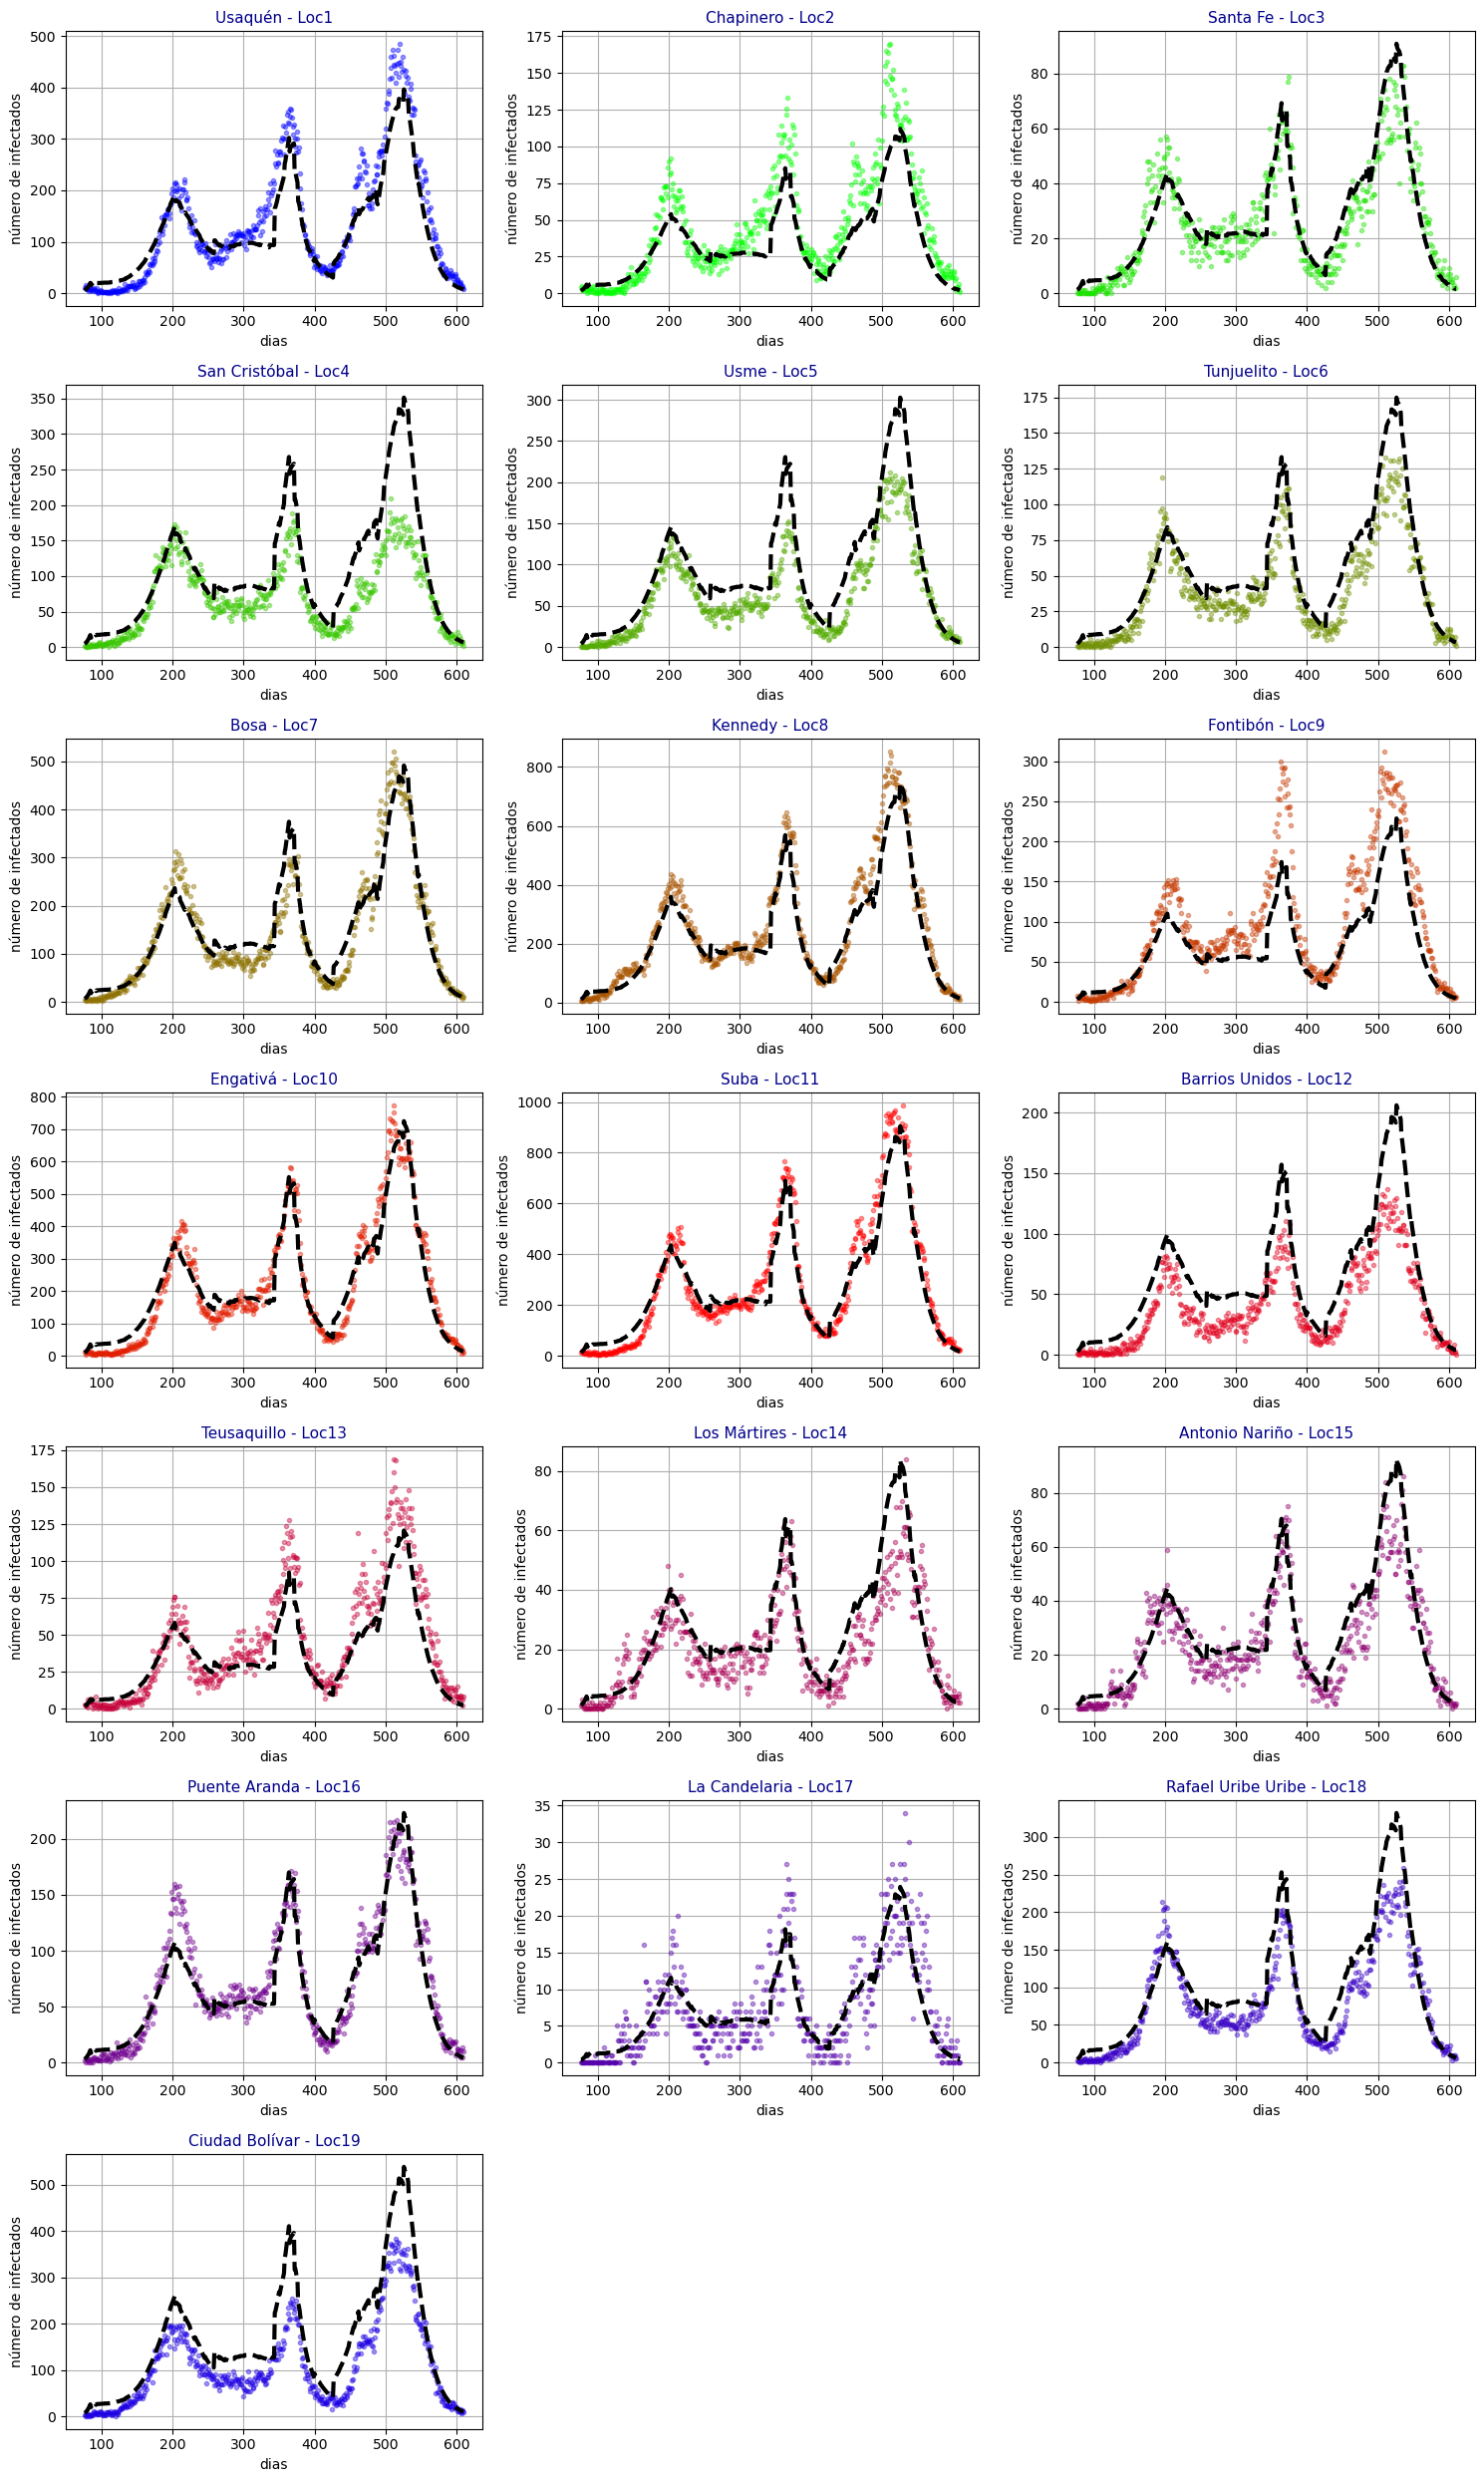

In [18]:
# Graficas 
fig, ax = plt.subplots(7,3,figsize=(15,25),dpi=100)
ax = ax.reshape(-1)
cmap = plt.get_cmap('brg')
colors = [cmap(k) for k in np.linspace(0, 1, 19)]
for i in np.arange(19)+1:
    loc = infectados[infectados["local_id"]==i] # Localidad i
    localidad = loc["Locality"].unique()[0]
    tiempo = loc["inf_day"].values
    casos_real = loc["new_infected_real"].values
    casos_sim = loc["infect_sim_por_sigma"].values
    ax[i-1].plot(tiempo, casos_real, '.', label="Reales", color=colors[-(i-1)], alpha=0.4)
    ax[i-1].plot(tiempo, casos_sim, label="Reales", lw=3, color="k", ls="--")
    # Propiedades gráficas
    ax[i-1].set_title(localidad + " - Loc"+str(i), fontsize=11, color="darkblue")
    ax[i-1].set_xlabel("dias")
    ax[i-1].set_ylabel("número de infectados")
    ax[i-1].grid()    
ax[-1].axis("off")
ax[-2].axis("off")
fig.tight_layout()

## <a id='Rt'></a> 10. Cálculo de $R_t$

$$ \Large \mathcal{R}(t) = \left( \cfrac{\varphi_{ei}}{\varphi_{ir} \gamma_{ir}  +  \varphi_{ih} \gamma_{ih} + \varphi_{iu} \gamma_{iu} + (1- \varphi_{ir}- \varphi_{ih}-\varphi_{iu}) \gamma_{id}} + \frac{(1-\varphi_{ei})\theta}{\varphi_{ar} \gamma_{a}} \right) \beta S $$

In [19]:
# Obteniendo parametros:
p_ir = float(epi_params['Prob_S_ymptomaticToRecover'])
g_ir = float(epi_params['TransitionRate_ir'])
p_ih = float(epi_params['Prob_S_ymptomaticToHospital'])
g_ih = float(epi_params['TransitionRate_ih'])
p_iu = float(epi_params['Prob_S_ymptomaticToUci'])
g_iu = float(epi_params['TransitionRate_iu'])
g_id = float(epi_params['TransitionRate_id'])
p_ar = float(epi_params['Prob_A_symptomaticToRecover'])
g_ar = float(epi_params['TransitionRate_ir'])

In [20]:
def calcularRt(info_bloques):
    estimados = np.zeros((111,611))
    for bloque in info_bloques.keys():

        # Fechas
        ini = fecha2dia(info_bloques[bloque]["day_ini_fit"])
        fin = fecha2dia(info_bloques[bloque]["day_fin_fit"])

        # Parametros calculados
        beta, p_ei, theta = info_bloques[bloque]['paramsCalculados']
        theta = 1-theta

        # Calculando susceptibles y poblacion
        SArray = np.load('outputs/statearray/'+bloque+'_out_statearray.npy')[:,:,1:]
        S, E, A, I, U, H, R, D, V, peaks, new_inf  = SArray
        poblacion = (S+E+A+I+U+H+R+D)[0]
        N = np.array(poblacion.reshape((111,-1)))
        S = S[:fin-ini].T

        # Calculando Rt
        a = p_ei / (p_ir*g_ir + p_ih*g_ih + p_iu*g_iu + (1 - p_ir-p_ih-p_iu)*g_id)
        b = (1-p_ei)*theta / (p_ar*g_ar)
        rt = (a+b)*beta*(S/N)

        # Guardando:
        estimados[:,ini:fin] = rt
        
    # Cargando paramfile
    paramfile2 = pd.read_csv('data/google_upz_ratio_transit_exp_2021.txt', delimiter=" ", dtype={0: str}, header=None)
    paramfile2 = paramfile2.values[:,1:fin+1]
    return paramfile2*estimados

In [21]:
# Hallando Rt
simular_nuevamente(ib1,epi_params)  # Parametros calculados 
Rt1 = calcularRt(ib1)

simular_nuevamente(ib2,epi_params) # Otros parametros calculados
Rt2 = calcularRt(ib2)

simular_nuevamente(ib3,epi_params) # Parametros del codigo del profesor
Rt3 = calcularRt(ib3)

Simulado.
Simulado.
Simulado.


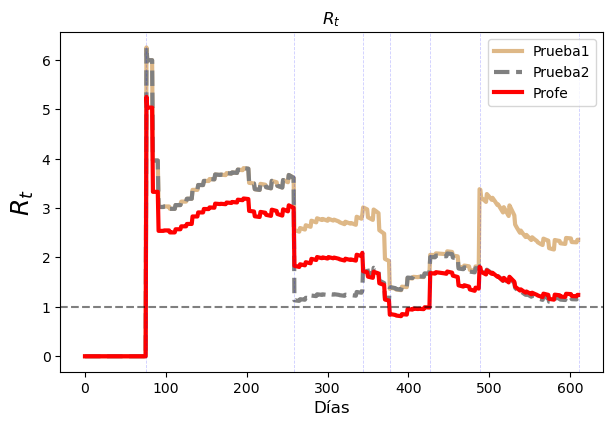

In [22]:
# Graficando
upzs, days = Rt1.shape
plt.figure(figsize=(7,4.5),dpi=100)
t = np.arange(days)
plt.plot(t,np.mean(Rt1,axis=0),ls="-", lw=3, label="Prueba1", c="burlywood") # parametros calculados 
plt.plot(t,np.mean(Rt2,axis=0),ls="--", lw=3, label="Prueba2", c="gray") # Otros parametros de prueba
plt.plot(t,np.mean(Rt3,axis=0),lw=3, label="Profe", c="r") # Parametros del profesor
plt.axhline(1, c='k', alpha = 0.5, ls="--")
[plt.axvline(i, c='b', alpha = 0.2, ls="--", lw=0.6) for i in [76, 259, 344, 377, 427, 488, 611]]
plt.xlabel('Días', fontsize = 12)
plt.ylabel(r'$R_t$', fontsize = 18)
plt.legend(fontsize=10)
plt.title(r"$R_t$")
plt.show()

## Identificando Hotspots

+ Calculando upzs que reciben la mayor cantidad de personas.

In [23]:
# parametros del Bloque 1:
beta, sigma, theta = 1.7211052758553387, 0.08521136025252125, 0.7125511375808415

# Matriz de movilidad
matriz = matriz_mov.rename(columns={"from":"origen","to":"destino"})

In [24]:
# Agrupando por destinos
Fi = matriz.groupby(["destino"]).mean().reset_index()[["destino","mov"]]
# Ordenando de menor a mayor
Fi = Fi.rename(columns={"mov":"flujo_in"}).sort_values("flujo_in") 
# Normalizando
Fi["flujoN"] = Fi["flujo_in"]/np.sum(Fi["flujo_in"])
# Flujo acumulado:
Fi["flujo_acum"] = np.cumsum(Fi["flujoN"])

In [25]:
# Tangente en un punto:
def tangente(y,p):
    x = np.arange(len(y))
    fprima = (y[p]-y[p-1])/1 # derivative
    tan = y[p]+fprima*(x-p)  # tangent
    return tan

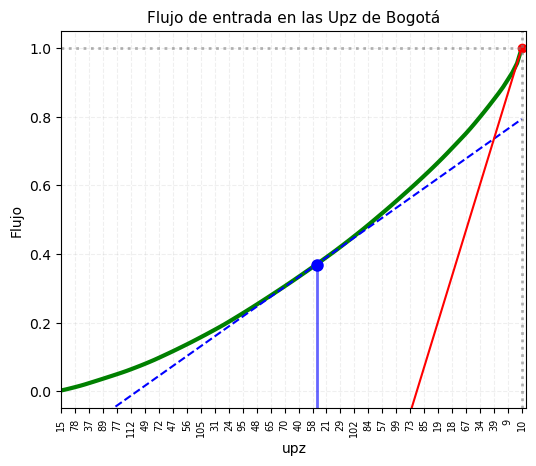

In [26]:
plt.figure(figsize=(6,5),dpi=100)
plt.title("Flujo de entrada en las Upz de Bogotá", fontsize=11)
# Graficando flujos
flujo = Fi.flujo_acum.values
promedio = np.mean(Fi.flujo_acum.values)
plt.plot(flujo, lw=3, c="g", label="entradas")
# Graficando promedio
i=0
while promedio>=flujo[i]: i+=1 # Posicion del promedio
plt.plot(i,promedio,'ob', ms=8)
plt.axvline(i, alpha = 0.6, lw=2, ymax=promedio, c="b") 
# Graficando tangente al promedio
tan = tangente(flujo,i)  # Tangente en el promedio
plt.plot(tan, ls="--", c="b")
# Graficando el maximo
plt.plot(len(Fi)-1, flujo[len(Fi)-1], 'or')
# Graficando tangente en el maximo
tan2 = tangente(flujo,len(Fi)-1)
plt.plot(tan2, ls="-", c="r")
# Propiedades graficas
plt.axvline(len(Fi)-1, alpha = 0.6, lw=2, c="gray", ls=":") 
plt.axhline(1, alpha = 0.6, lw=2, c="gray", ls=":") 
plt.xlim(0,len(Fi))
plt.xticks(np.arange(0,len(Fi),3), Fi.destino[::3], fontsize=7, rotation=90)
plt.xlabel("upz"),plt.ylabel("Flujo")
plt.ylim(-0.05,1.05)
plt.grid(ls='--',alpha=0.2)
plt.show()

In [27]:
UPZs = Fi.destino.values
# UPZ mayores que el promedio:
j=0
while tan[j]<=0: j+=1
upz_prom = UPZs[j:]
# UPZ mayores que el maximo:
k=0
while tan2[k]<=0: k+=1
upz_max = UPZs[k:]

<Figure size 432x864 with 0 Axes>

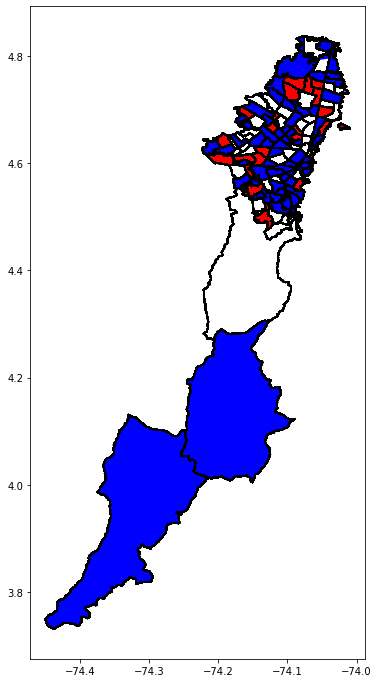

In [28]:
import seaborn as sns
import shapefile as shp
#sns.set(style="whitegrid", palette="pastel", color_codes=True)
#sns.mpl.rc("figure", figsize=(10,6))
sf = shp.Reader("upzs/UPla.shp")

plt.figure(figsize = (6,12))
fig, ax = plt.subplots(figsize = (6,12))
def plot_map_fill(id, sf, x_lim = None, y_lim = None, color = 'r'):
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k')
    shape_ex = sf.shape(id)
    x_lon = np.zeros((len(shape_ex.points),1))
    y_lat = np.zeros((len(shape_ex.points),1))
    for ip in range(len(shape_ex.points)):
        x_lon[ip] = shape_ex.points[ip][0]
        y_lat[ip] = shape_ex.points[ip][1]
    ax.fill(x_lon,y_lat, color)  
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)
#plot_map_fill(0, sf, x_lim, y_lim, color=’y’)
[plot_map_fill(i, sf,color="b") for i in upz_prom]
[plot_map_fill(i, sf,color="r") for i in upz_max]
plt.show()